# Almgren-Chriss Optimal Liquidation Model

*Louis Nguyen, 11/14/2025*

The Almgren-Chriss model is used to balance tradeoff between temporary & permanent market impacts due to the liquidation process and price volativity exposure. In simple words, selling fast from a big position may create severe market impacts while selling slow may suffer from price fluctuations. In this notebook, I will implement a nonlinear programming solution to find this "equilibrium" 

**Citation**: Almgren, Robert, and Neil Chriss. “Optimal Execution of Portfolio Transactions.” The Journal of Risk, vol. 3, no. 2, Jan. 2001, pp. 5–39, https://doi.org/10.21314/jor.2001.041. Accessed 30 Aug. 2019.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.linalg import sqrtm

## Experiment 1: Single Asset

First, we will try implement Almgren-Chriss model with financial data for a single asset. Specifically, we will analyze optimal liquidation trajectory with daily prices of Lockheed Martin Corp (NYSE: LMT) during the past 12 months

### Data 

In [2]:
lmt = yf.Ticker('LMT')
data = lmt.history(period='12mo')
display(data)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-11-15 00:00:00-05:00,523.154071,527.696285,516.880529,520.197266,1757100,0.0,0.0
2024-11-18 00:00:00-05:00,521.724394,523.261124,514.273935,516.433228,1298400,0.0,0.0
2024-11-19 00:00:00-05:00,522.385782,524.564487,516.676387,518.670288,935700,0.0,0.0
2024-11-20 00:00:00-05:00,519.565035,520.586296,514.721305,520.099976,994300,0.0,0.0
2024-11-21 00:00:00-05:00,520.498752,529.777719,519.117560,527.180786,1321700,0.0,0.0
...,...,...,...,...,...,...,...
2025-11-10 00:00:00-05:00,456.000000,457.100006,448.480011,452.100006,1630100,0.0,0.0
2025-11-11 00:00:00-05:00,451.769989,461.769989,451.000000,457.070007,1322100,0.0,0.0
2025-11-12 00:00:00-05:00,456.140015,459.769989,455.220001,457.040009,935400,0.0,0.0


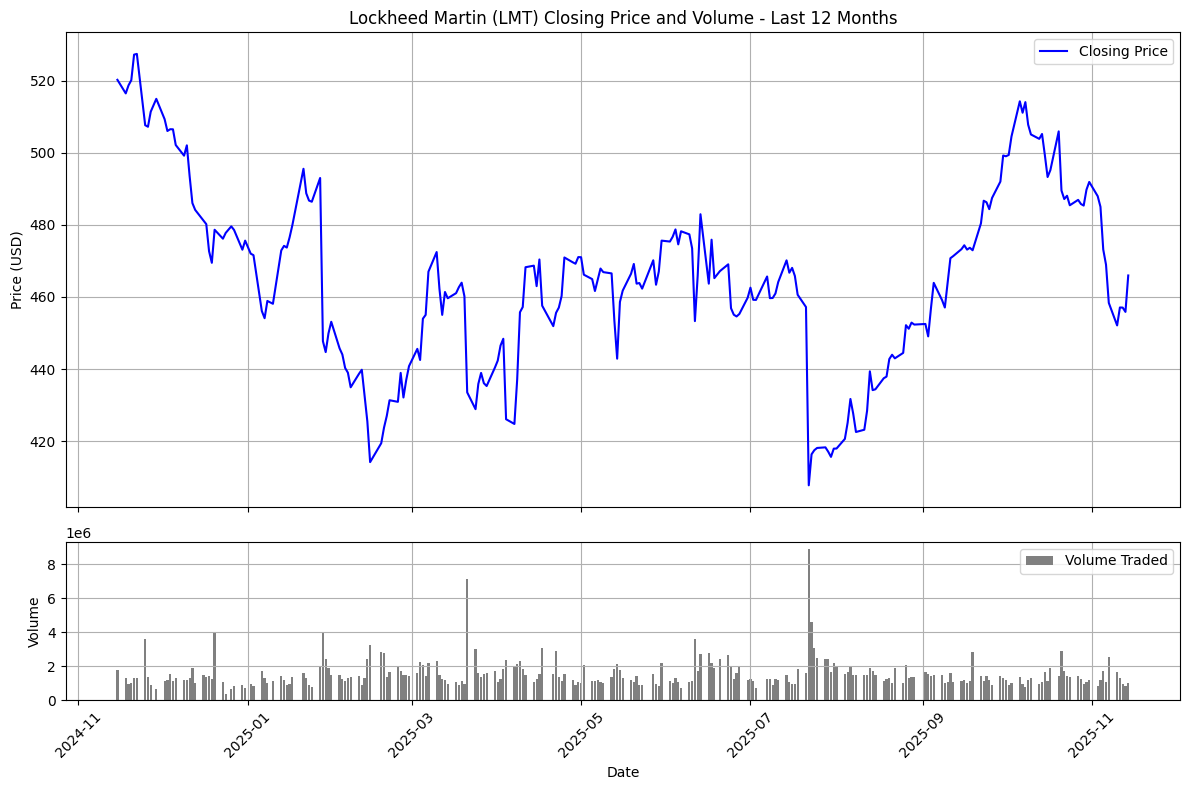

In [3]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})

# Plot closing price 
ax1.plot(data.index, data['Close'], label='Closing Price', color='blue')
ax1.set_ylabel('Price (USD)')
ax1.set_title('Lockheed Martin (LMT) Closing Price and Volume - Last 12 Months')
ax1.grid(True)
ax1.legend()

# Plot volume 
ax2.bar(data.index, data['Volume'], label='Volume Traded', color='gray')
ax2.set_ylabel('Volume')
ax2.set_xlabel('Date')
ax2.grid(True)
ax2.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Parameters

Let X be the initial position or the amount of stocks we want to liquidate and T be the time we have to set X to 0.

- $\lambda$ is risk-aversion paremeter, with larger $\lambda$ indicating more "averse" attitude for risk
- $\sigma$ is volativity, calculated by the standard deviation of daily price
- $\epsilon$ is temporary market impact parameter, calculated as half of bid/ask spread + fees
- $\eta$ is also temporary market impact parameter, depending on complex and transient microstructure dynamics such as short-term supply-demand imbalances. 
- $\gamma$ is permanent market impact paremeter. To keep it simple, $n$ units sold will decrease per-unit price by $n\gamma$ 
- $\tau$ is the size of the period in which we can trade. We will take $\tau$ to be 1 day for simplicity.

Temporary impact $h(v)$ and permanent impact $g(v)$ are modelled as 

$$h(v) = \epsilon sign(v) + \eta(\dfrac{v}{\tau})^{\beta}$$

$$g(v) = \gamma v^{\alpha}$$

We will use the closing price as the daily price of the stock. As we do not have real pre-trade, during-trade, and post-trade data to set up a regression model for $\eta$ and $\gamma$, we will assume and calibrate these params as

$$\eta = \dfrac{\text{Spread}}{0.01 \times \text{Avg. Daily Volumn}}$$

$$\gamma = \dfrac{\text{Spread}}{0.1 \times \text{Avg. Daily Volumn}}$$



In [4]:
avg_daily_vol = np.mean(data['Volume'])
avg_daily_spread = np.mean(data['High'] - data['Low'])

sigma = np.std(data['Close'])
epsilon = avg_daily_spread/2
tau = 1
eta = avg_daily_spread/(0.01*avg_daily_vol)
gamma = avg_daily_spread/(0.1*avg_daily_vol)

params = {
    'lambda': 1e-8,
    'sigma': sigma,
    'epsilon': epsilon,
    'tau': tau,
    'eta': eta,
    'gamma': gamma,
}

for key, value in params.items():
    print(f"{key}: {value}")

lambda: 1e-08
sigma: 24.94539583460439
epsilon: 4.628466868207373
tau: 1
eta: 0.0005980961006847046
gamma: 5.980961006847046e-05


### Implementation

A trajectory is the vector $(x_0, x_1, ..., x_N)$ where $x_k$ is the number of units of the asset that we hold at time $t_k$. Given the above params class, we can compute the optimal trading trajectory with inputs X (initial position) and T (time to liquidate all), using following equations

$$\tilde{\eta} = \eta - \dfrac{\gamma\tau}{2}$$

$$\tilde{\kappa}^2 = \dfrac{\lambda\sigma^2}{\tilde{\eta}}$$

$$\kappa = \dfrac{1}{\tau}\text{arccosh}\left(\dfrac{\tilde{\kappa}^2\tau^2}{2}+1\right)$$

$$x_k = \dfrac{\sinh(\kappa(T-t_k))}{\sinh(\kappa T)}



In [5]:
class Almgren_Chriss:
    def __init__(self, params):
        self.eta_tilda = params['eta'] - 0.5*params['lambda']*params['tau']
        assert self.eta_tilda > 0 
        self.kappa_tilda_sq = (params['lambda']*(params['sigma']**2))/self.eta_tilda
        self.kappa = np.arccosh(0.5*self.kappa_tilda_sq*(params['tau']**2)+1)/params['tau']

    def make_trajectory(self, X, T):
        w = []
        for t in range(T):
            x = np.sinh(self.kappa*(T - t))/np.sinh(self.kappa*T)
            w.append(x)
        w.append(0)
        return np.array(w)
    
    def make_strategy(self, X, T):
        return np.diff(self.make_trajectory(X,T))

### Example

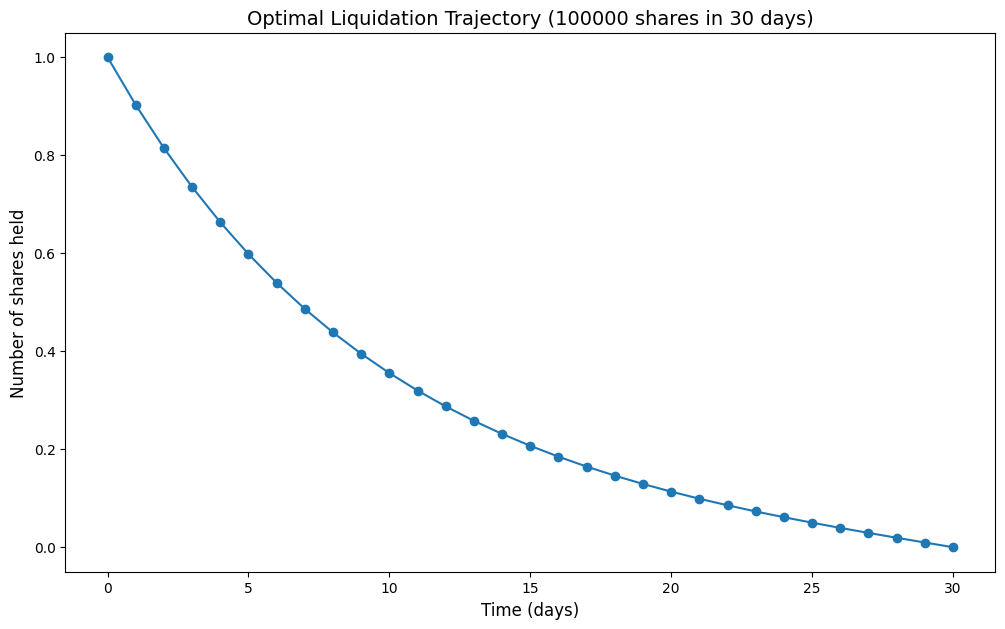

In [6]:
X = 100000
T = 30

model = Almgren_Chriss(params)
trajectory = model.make_trajectory(X,T)

plt.figure(figsize=(12,7))
plt.plot(range(T+1),trajectory,'o-')
plt.title(f'Optimal Liquidation Trajectory ({X} shares in {T} days)',fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.show()

### Parameter Testing

We will experiment and see how the trajectory changes with different parameter values of risk-aversion ($\lambda$)

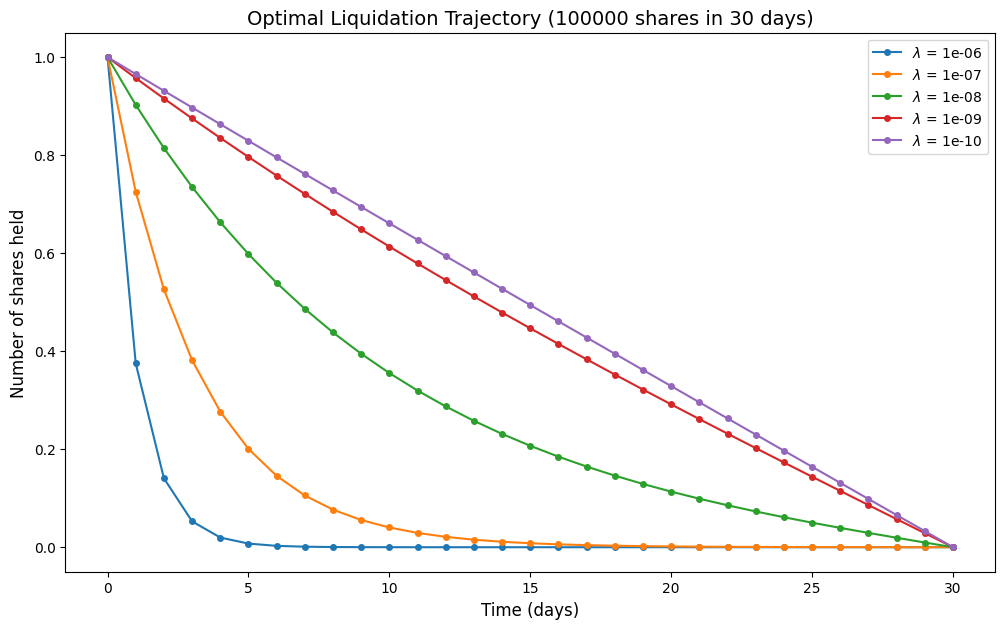

In [23]:
lambdas = [1e-6, 1e-7, 1e-8, 1e-9, 1e-10]

plt.figure(figsize=(12,7))
for _lambda in lambdas:
    _params = params.copy()
    _params['lambda'] = _lambda
    model = Almgren_Chriss(_params)
    trajectory = model.make_trajectory(X,T)
    plt.plot(range(T + 1), trajectory, 'o-', ms=4, label=rf'$\lambda$ = {_lambda:.0e}')

plt.title(f'Optimal Liquidation Trajectory ({X} shares in {T} days)',fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.legend()
plt.show()

It is easy to see that with smaller risk-aversion, the liquidation rate is nearly constant. The agent does not concern with price volativity and focus on minimizing market impact cost. While with larger risk-aversion, the agent will not want to hold the position too long. In this case, a fast liquidation will create huge transaction cost due to extreme market impact.

## Experiment 2: Multiple Assets

We will now implement the Almgren-Chriss model on financial data of th correlated assets, namely Lockheed Martin Corp (NYSE: LMT) and Northrop Grumman Corp (NYSE: NOC)

### Data

In [27]:
lmt = yf.Ticker('LMT')
data1 = lmt.history(period='12mo')
display(data1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-11-15 00:00:00-05:00,523.154071,527.696285,516.880529,520.197266,1757100,0.0,0.0
2024-11-18 00:00:00-05:00,521.724333,523.261062,514.273874,516.433167,1298400,0.0,0.0
2024-11-19 00:00:00-05:00,522.385782,524.564487,516.676387,518.670288,935700,0.0,0.0
2024-11-20 00:00:00-05:00,519.565035,520.586296,514.721305,520.099976,994300,0.0,0.0
2024-11-21 00:00:00-05:00,520.498812,529.777780,519.117620,527.180847,1321700,0.0,0.0
...,...,...,...,...,...,...,...
2025-11-10 00:00:00-05:00,456.000000,457.100006,448.480011,452.100006,1630100,0.0,0.0
2025-11-11 00:00:00-05:00,451.769989,461.769989,451.000000,457.070007,1322100,0.0,0.0
2025-11-12 00:00:00-05:00,456.140015,459.769989,455.220001,457.040009,935400,0.0,0.0


In [28]:
noc = yf.Ticker('NOC')
data2 = noc.history(period='12mo')
display(data1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-11-15 00:00:00-05:00,523.154071,527.696285,516.880529,520.197266,1757100,0.0,0.0
2024-11-18 00:00:00-05:00,521.724333,523.261062,514.273874,516.433167,1298400,0.0,0.0
2024-11-19 00:00:00-05:00,522.385782,524.564487,516.676387,518.670288,935700,0.0,0.0
2024-11-20 00:00:00-05:00,519.565035,520.586296,514.721305,520.099976,994300,0.0,0.0
2024-11-21 00:00:00-05:00,520.498812,529.777780,519.117620,527.180847,1321700,0.0,0.0
...,...,...,...,...,...,...,...
2025-11-10 00:00:00-05:00,456.000000,457.100006,448.480011,452.100006,1630100,0.0,0.0
2025-11-11 00:00:00-05:00,451.769989,461.769989,451.000000,457.070007,1322100,0.0,0.0
2025-11-12 00:00:00-05:00,456.140015,459.769989,455.220001,457.040009,935400,0.0,0.0


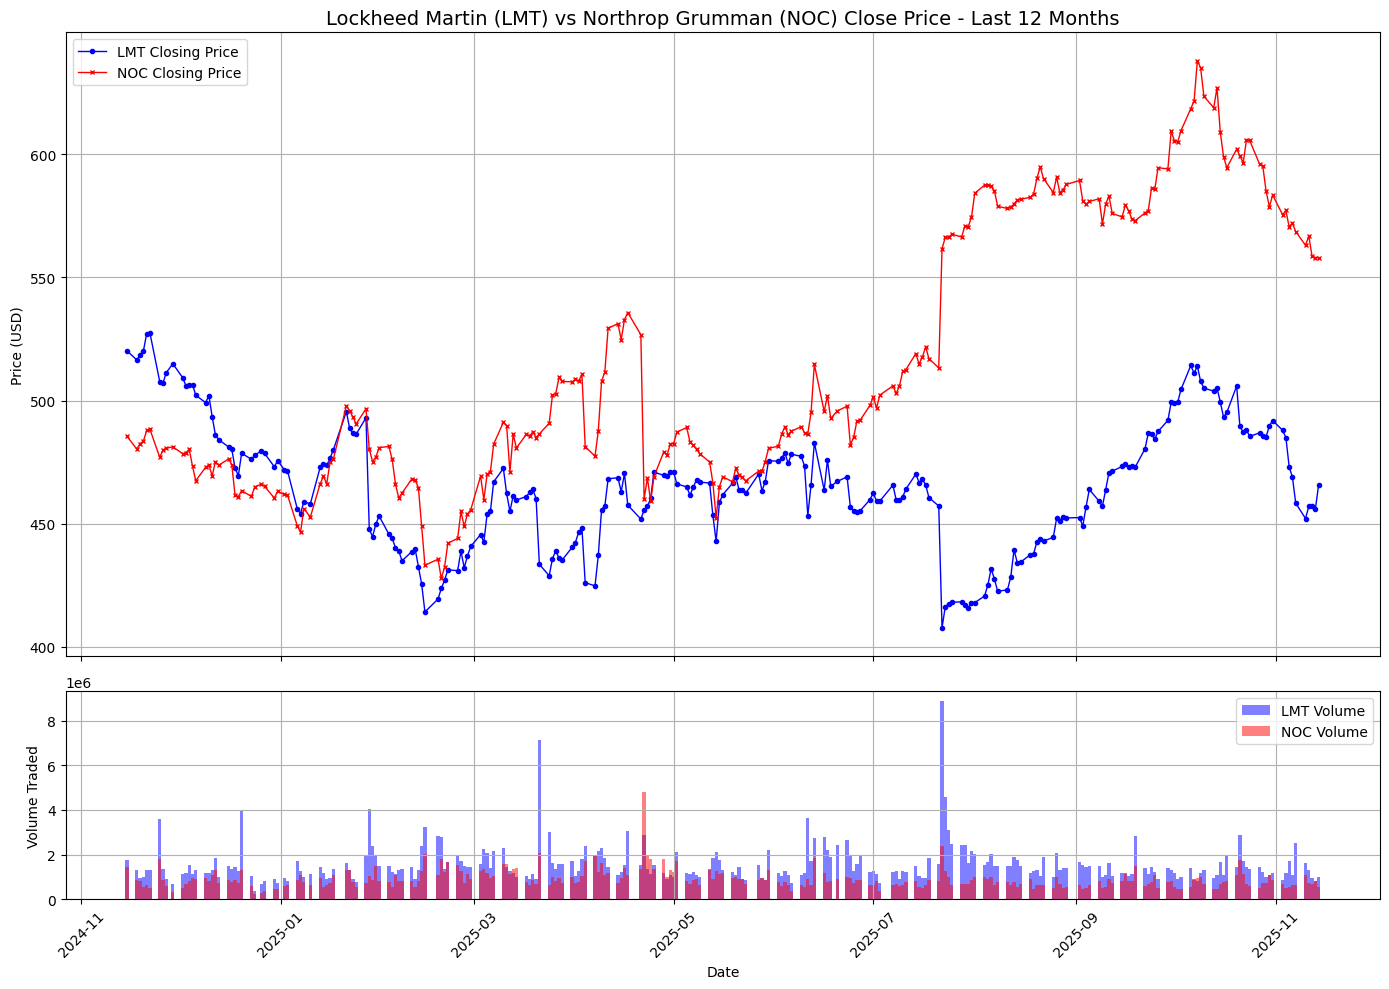

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})

# Plot closing prices for both stocks 
ax1.plot(data1.index, data1['Close'], label='LMT Closing Price', color='blue', marker='o', markersize=3, linewidth=1)
ax1.plot(data2.index, data2['Close'], label='NOC Closing Price', color='red', marker='x', markersize=3, linewidth=1)
ax1.set_ylabel('Price (USD)')
ax1.set_title('Lockheed Martin (LMT) vs Northrop Grumman (NOC) Close Price - Last 12 Months', fontsize=14)
ax1.grid(True)
ax1.legend()

# Plot volume traded for both stocks 
width = 1.0  
ax2.bar(data1.index, data1['Volume'], label='LMT Volume', color='blue', alpha=0.5, width=width)
ax2.bar(data2.index, data2['Volume'], label='NOC Volume', color='red', alpha=0.5, width=width)
ax2.set_ylabel('Volume Traded')
ax2.set_xlabel('Date')
ax2.grid(True)
ax2.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Parameter

We will have some new parameters generalized from the old ones to deal with multiple stocks
- $C$ is the variance-covariance matrix, which measures the volatility of all assets and how they are correlated
- $\Gamma$ is the permanent impact parameter matrix, with value at $(i,j)$ representing asset $i$'s price depression caused by selling an unit of asset $j$
- $H$ is is the temporary impact parameter matrix, with value at $(i,j)$ defined the same as $\Gamma$

For simplicity, we calibrate $\Gamma$ and $H$ as followed
$$
H = 
\begin{bmatrix}
\quad \dfrac{\text{spread}_1}{0.01 \times \text{avg. volume}_1 } & 0 \\
0 & \dfrac{\text{spread}_2}{0.01 \times \text{avg. volume}_2} \quad
\end{bmatrix}
$$

$$
\Gamma = 
\begin{bmatrix}
\quad \dfrac{\text{spread}_1}{0.1 \times \text{avg. volume}_1 } & 0 \\
0 & \dfrac{\text{spread}_2}{0.1 \times \text{avg. volume}_2} \quad
\end{bmatrix}
$$

In [30]:
avg_vol_1 = np.mean(data1['Volume'])
avg_vol_2 = np.mean(data2['Volume'])
avg_spr_1 = np.mean(data1['High'] - data1['Low'])
avg_spr_2 = np.mean(data2['High'] - data2['Low'])

C = np.cov(data1['Close'], data2['Close'])

epsilon = (avg_spr_1 + avg_spr_2)/2

H = [[avg_spr_1/(0.01*avg_vol_1), 0], [0, avg_spr_2/(0.01*avg_vol_2)]]
G = [[avg_spr_1/(0.1*avg_vol_1), 0], [0, avg_spr_2/(0.1*avg_vol_2)]]

tau = 1

params = {
    'lambda': 1e-08,
    'C': C,
    'epsilon': epsilon,
    'H': H,
    'Gamma': G,
    'tau': tau
}

for key, value in params.items():
    print(f"{key}: {value}")

lambda: 1e-08
C: [[ 624.77038832  142.97322599]
 [ 142.97322599 2834.75347095]]
epsilon: 9.797779415372474
H: [[np.float64(0.0005980960999389455), 0], [0, np.float64(0.0011466966693358044)]]
Gamma: [[np.float64(5.980960999389455e-05), 0], [0, np.float64(0.00011466966693358042)]]
tau: 1


### Implementation

